# YouNiverse: Video metadata analysis

In [2]:
import findspark
findspark.init()

In [3]:
%matplotlib inline

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark.sql.functions import year, month
import pyspark.sql.functions as func
from pyspark.sql import SparkSession

spark = SparkSession           \
        .builder               \
        .appName("Youniverse") \
        .getOrCreate()

import pyspark.pandas as ps
ps.set_option("plotting.backend", "matplotlib")

plt.style.use("ggplot")

In [4]:
PATH_METADATA_SRC = "data/yt_metadata_en.jsonl"
VIDEO_COUNT = 72924794 # The number of data points in the dataset. This result is obtained in a cell below

Note that if you are using a Unix system, use rather the command
```shell
head -n 2 ./data/yt_metadata_en.jsonl
```
by uncommenting the first line and commenting the other.

In [ ]:
#!head -n 2 $PATH_METADATA_SRC
!PowerShell.exe gc "$PATH_METADATA_SRC" -head 2

In [6]:
schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("description",   StringType(),  True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True)  # This field must be specified as a double as it is represented as a floating point number
])

metadatas_df = spark.read.json(PATH_METADATA_SRC, schema=schema)

# Cast the dislike_count, like_count and view_count to their respective integer type
metadatas_df = metadatas_df \
    .withColumn("dislike_count", metadatas_df.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", metadatas_df.like_count.cast(IntegerType())) \
    .withColumn("view_count", metadatas_df.view_count.cast(LongType()))

In [7]:
metadatas_df.printSchema()

root
 |-- categories: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- crawl_date: date (nullable = true)
 |-- description: string (nullable = true)
 |-- dislike_count: integer (nullable = true)
 |-- display_id: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- title: string (nullable = true)
 |-- upload_date: date (nullable = true)
 |-- view_count: long (nullable = true)



In [8]:
# We convert the pyspark dataframe into a pyspark.pandas dataframe
ps_metadatas_df = metadatas_df.pandas_api(index_col="display_id")

In [9]:
# We can see that pandas API provides a better a nicer looking presentation of the dataframe than Spark's own API
ps_metadatas_df.head(5)

,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,upload_date,view_count
display_id,,,,,,,,,,,
SBqSc91Hn9g,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31,Lego City Police Lego Firetruck Cartoons about...,1,1159,8,"lego city,lego police,lego city police,lego ci...",Lego City Police Lego Firetruck Cartoons about...,2016-09-28,1057
UuugEl86ESY,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31,Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,1,2681,23,"Lego superheroes,lego hulk,hulk smash,lego mar...",Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,2016-09-28,12894
oB4c-yvnbjs,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31,Lego City Police Lego Fireman Cartoons about L...,779,1394,1607,"lego city,lego police,lego city police,lego fi...",Lego City Police Lego Fireman Cartoons about L...,2016-09-28,1800602
ZaV-gTCMV8E,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31,Lego Harry Potter Complete Lego New Movie for ...,24,5064,227,"Lego harry potter,new harry potter,harry potte...",Lego Harry Potter Complete Lego New Movie for ...,2016-09-28,57640
cGvL7AvMfM0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31,Lego City Police LONG VIDEO for kids Lego Fire...,13,3554,105,"lego city,lego police,lego city police,lego fi...",Lego City Police 1 HOUR LONG VIDEO for kids Le...,2016-09-28,86368


## Basic visualisations

Let us select only relevant categories and plot histograms for the numerical values

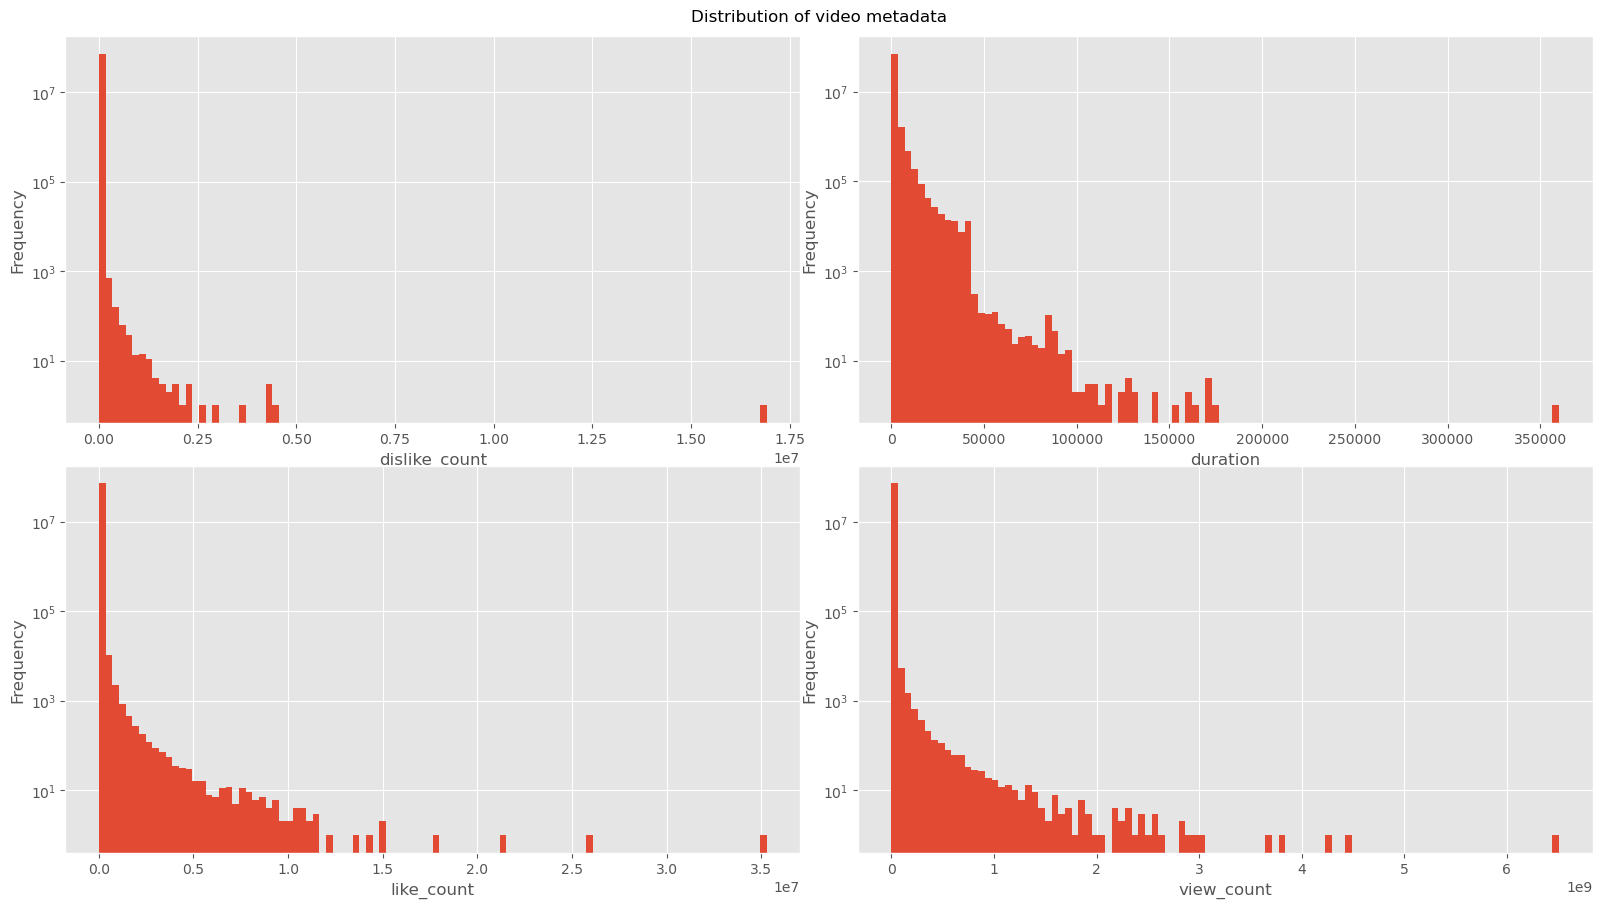

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
fig.tight_layout()
for i, ax in enumerate(axes.flatten()):
    ps_metadatas_df[["dislike_count", "duration", "like_count", "view_count"]].iloc[:, i].plot.hist(ax=ax, bins=100)
    ax.set_yscale('log')
    ax.set_xlabel(ps_metadatas_df[["dislike_count", "duration", "like_count", "view_count"]].columns[i])
fig.suptitle("Distribution of video metadata")
fig.subplots_adjust(top=0.95)

We can see that all the values follow basically a heavy-tailed distribution.

In [12]:
# We compute the correlation on only the numerical values
corr = ps_metadatas_df[["dislike_count", "duration", "like_count", "view_count"]].dropna().corr()
sns.heatmap(corr.to_pandas(), annot=True)

We can see the `like_count` and the `view_count` are highly corrolated. This seems logical as the more views a video has, the more people could like it.

## Basic visualisation with a random subsample

As we have a big dataset, one might ask what would happen if we take a random smaller sample from the dataset. We hence reproduce the same histogram but by taking only 0.1\% of the total data to plot these.

In [20]:
# We select only a small subsample from the dataset without replacement and convert it to a pandas dataframe
random_sub = metadatas_df.select("dislike_count", "duration", "like_count", "view_count").sample(withReplacement=False, fraction=0.001, seed=None).toPandas()

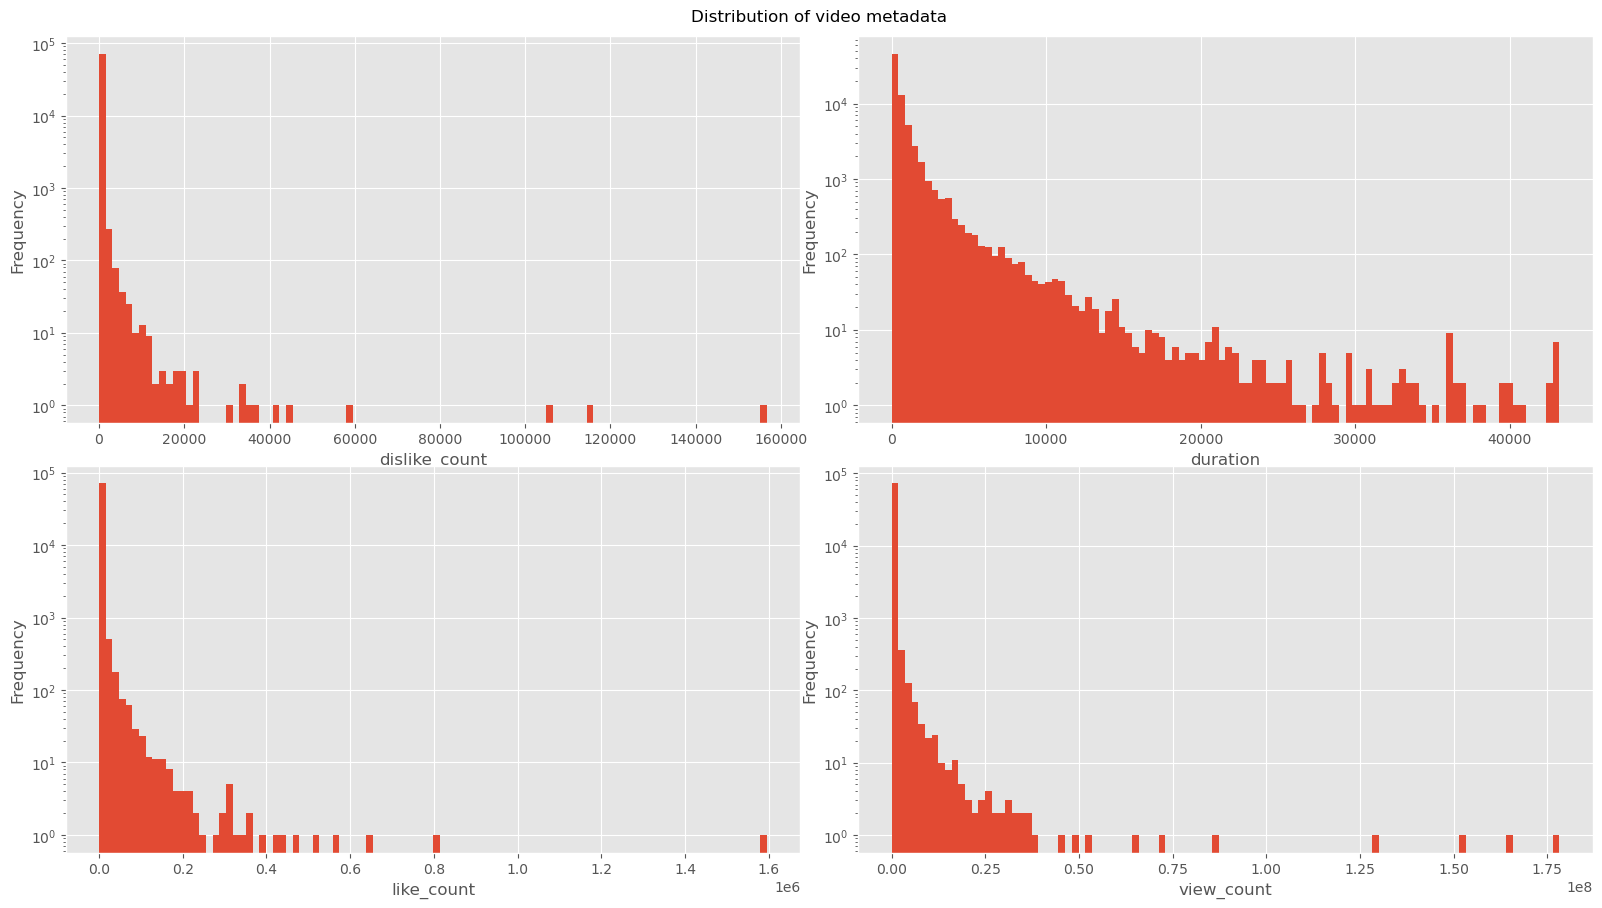

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
fig.tight_layout()
for i, ax in enumerate(axes.flatten()):
    random_sub.iloc[:, i].plot.hist(ax=ax, bins=100)
    ax.set_yscale('log')
    ax.set_xlabel(random_sub.columns[i])
fig.suptitle("Distribution of video metadata")
fig.subplots_adjust(top=0.95)

We can see that the distributions looks similar to the one with all datapoints with the exception of "outliars".

<AxesSubplot:>

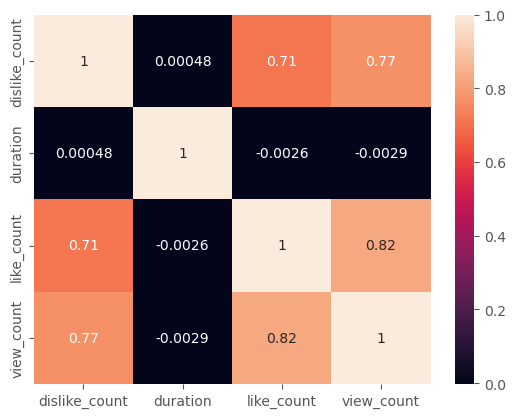

In [21]:
sns.heatmap(random_sub.corr(), annot=True)

## Missing values

We now check for any missing values in the dataset.

In [ ]:
# We take all the dataset, including display_id which was set as the index in the previous dataframe
metadatas_df.pandas_api().isnull().any()

categories       False
channel_id       False
crawl_date       False
description      False
dislike_count     True
display_id       False
duration         False
like_count        True
tags             False
title            False
upload_date      False
view_count        True
dtype: bool

Here we check if any columns contains NaN values and we can see that `dislike_count`, `like_count` and `view_count` contain null values.

In [12]:
missing_value_count = ps_metadatas_df[["dislike_count", "like_count", "view_count"]].isna().sum(axis=0)

In [ ]:
missing_value_count = missing_value_count.to_pandas()

In [15]:
# Here is the number of missing values
missing_value_count

dislike_count    1631458
like_count       1631458
view_count           654
dtype: int64

In [21]:
# The ratio of missing values
for col, x in (missing_value_count / VIDEO_COUNT).items():
    print(f"{col:14}: {x:.3%}")

dislike_count : 2.237%
like_count    : 2.237%
view_count    : 0.001%


## Basic statistics on numerical values

In [9]:
metadatas_df.select("dislike_count", "duration", "like_count", "view_count").summary().show()

+-------+------------------+------------------+------------------+------------------+
|summary|     dislike_count|          duration|        like_count|        view_count|
+-------+------------------+------------------+------------------+------------------+
|  count|          71293336|          72924794|          71293336|          72924140|
|   mean|  76.0915862037933| 757.6761375561788|1306.7580320831107|125237.60820707656|
| stddev|3064.7580067517442|1820.1105064271235|20135.880453098183|  3534488.21672248|
|    min|                 0|                 1|                 0|                 0|
|    25%|                 0|               134|                 6|               532|
|    50%|                 2|               284|                43|              2925|
|    75%|                12|               697|               265|             17423|
|    max|          16916346|            360157|          35287325|        6509934494|
+-------+------------------+------------------+-------

## Total number of video entries

In [10]:
# This cell was used to define the VIDEO_COUNT constant above
metadatas_df.count()

72924794

There are $72924794$ videos in total.

# Number of videos created each month

In [9]:
# Extract year from upload_date
df_dates = metadatas_df\
    .withColumn("year", year(metadatas_df.upload_date))\
    .withColumn("month", month(metadatas_df.upload_date))
df_dates.printSchema()

root
 |-- categories: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- crawl_date: date (nullable = true)
 |-- dislike_count: integer (nullable = true)
 |-- display_id: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- title: string (nullable = true)
 |-- upload_date: date (nullable = true)
 |-- view_count: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [10]:
# Group the videos by year and month and count the number of such videos
vids_per_month = df_dates.select("display_id", "year", "month").groupBy("year", "month").count()
count_sorted = vids_per_month.toPandas() \
    .sort_values(["year", "month"])
count_sorted["date"] = pd.to_datetime(count_sorted["year"].astype(str) + count_sorted["month"].astype(str), format="%Y%m")

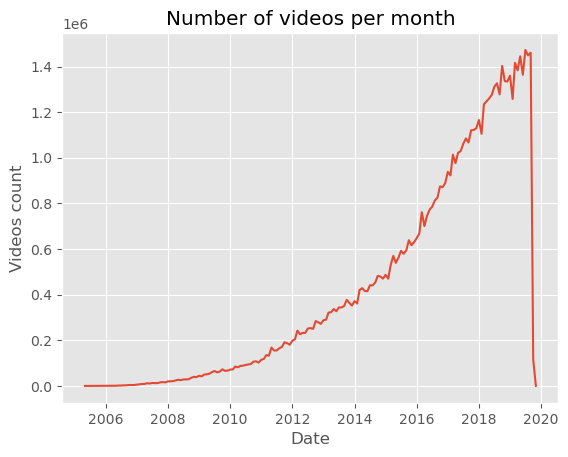

In [14]:
sns.lineplot(data=count_sorted, x="date", y="count")
plt.title("Number of videos per month")
plt.xlabel("Date")
plt.ylabel("Videos count")
plt.show()

We can see that the number of videos published every month grows in a somewhat exponential manner. We can see that at the end of 2019, the count drastically drops. This is simply explained by the fact that the crawling stoped at that time and hence we did not get a full month of video crawling.

# Group videos by year and categories

In [15]:
# Group the videos by year and month and count the number of such videos
count_cat = df_dates.select("display_id", "categories", "year") \
    .groupBy("year", "categories") \
    .count() \
    .toPandas()
count_cat.head()

In [18]:
# We list the categories that exist for videos
cats = set()
for x in count_cat.categories:
    cats.add(x)
cats

{'',
 'Autos & Vehicles',
 'Comedy',
 'Education',
 'Entertainment',
 'Film & Animation',
 'Gaming',
 'Howto & Style',
 'Movies',
 'Music',
 'News & Politics',
 'Nonprofits & Activism',
 'People & Blogs',
 'Pets & Animals',
 'Science & Technology',
 'Shows',
 'Sports',
 'Travel & Events'}

In [19]:
count_cat_idx = count_cat.set_index(['year', 'categories']) \
    .unstack(fill_value=0)["count"] \
    .unstack() \
    .reset_index(name='count') \
    .reset_index()

In [21]:
stack = {}
years = range(2005, 2020)
for cat in cats:
    stack[cat] = count_cat_idx[count_cat_idx["categories"] == cat].sort_values("year")["count"].values
stack['None'] = stack.pop('')

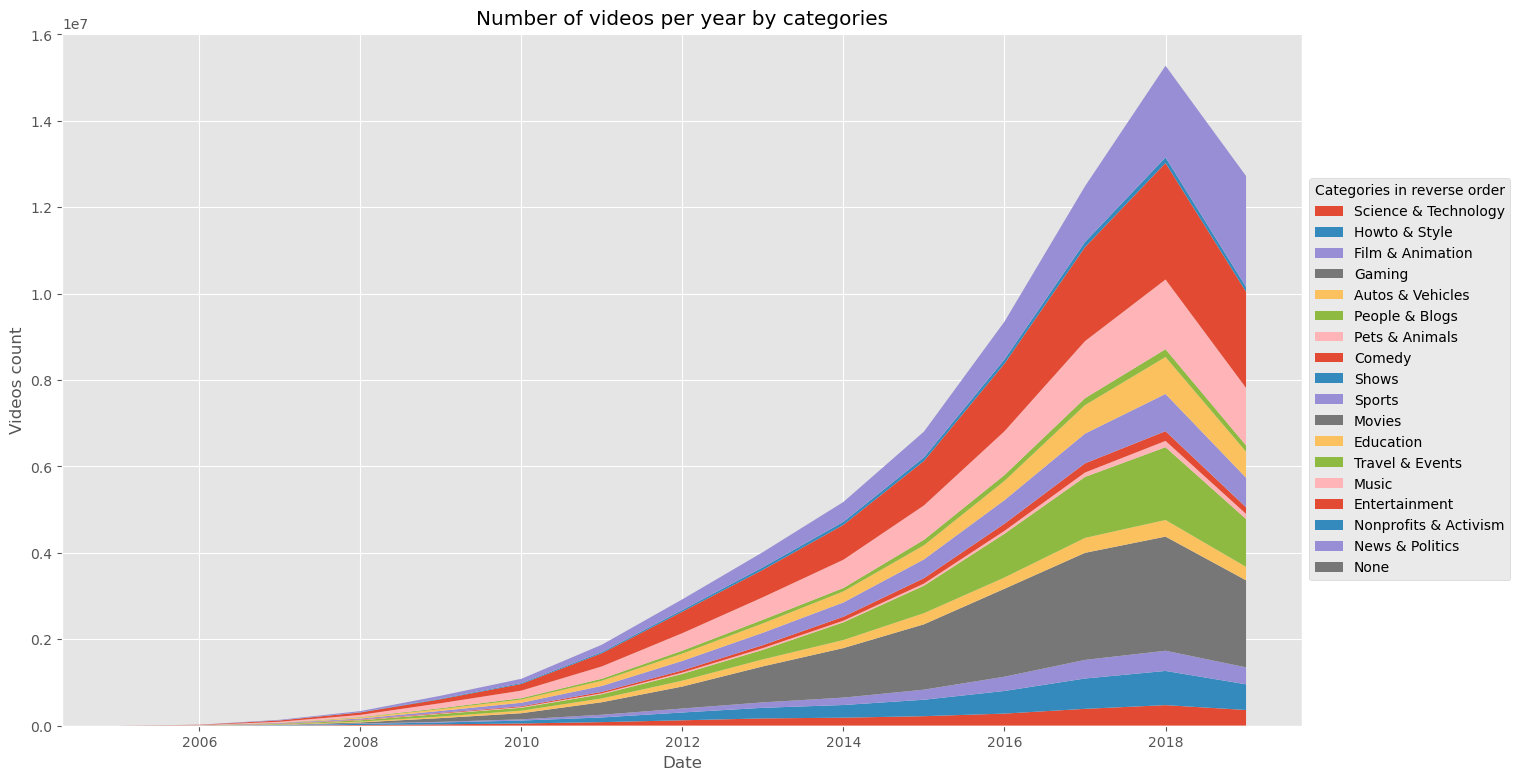

In [22]:
plt.figure(figsize=(16, 9))
plt.stackplot(years, stack.values(), labels=stack.keys())
plt.title("Number of videos per year by categories")
plt.xlabel("Date")
plt.ylabel("Videos count")
# plt.yscale('log')
plt.legend(
    title="Categories in reverse order", loc="center left", bbox_to_anchor=(1, 0.5)
)
plt.show()

In [35]:
count_cat_idx = count_cat_idx.drop("index", axis=1)
vids_per_year = count_cat_idx.groupby(["year"])["count"].sum()

In [57]:
# Compute the ratio of videos for each category
ratios = count_cat_idx.copy()
ratios["ratio"] = ratios.groupby(["year"])["count"].apply(lambda x: x / x.sum())

In [63]:
# Verify that the sum of all ratios gives 100%
ratios.groupby("year")["ratio"].sum()

year
2005    1.0
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
Name: ratio, dtype: float64

In [131]:
# The categories conain a category that is '' so we replace it by 'None' to give a better meaning
ratios.categories = ratios.categories.replace('', 'None')

In [132]:
# Ratios per category in 2011
ratios[ratios.year == 2011]

,categories,year,count,ratio
6,None,2011,162,0.000086
21,Autos & Vehicles,2011,88574,0.047240
36,Comedy,2011,32902,0.017548
51,Education,2011,120596,0.064318
66,Entertainment,2011,304094,0.162185
81,Film & Animation,2011,62429,0.033296
96,Gaming,2011,290048,0.154694
111,Howto & Style,2011,108199,0.057707
126,Movies,2011,0,0.000000
141,Music,2011,285111,0.152060


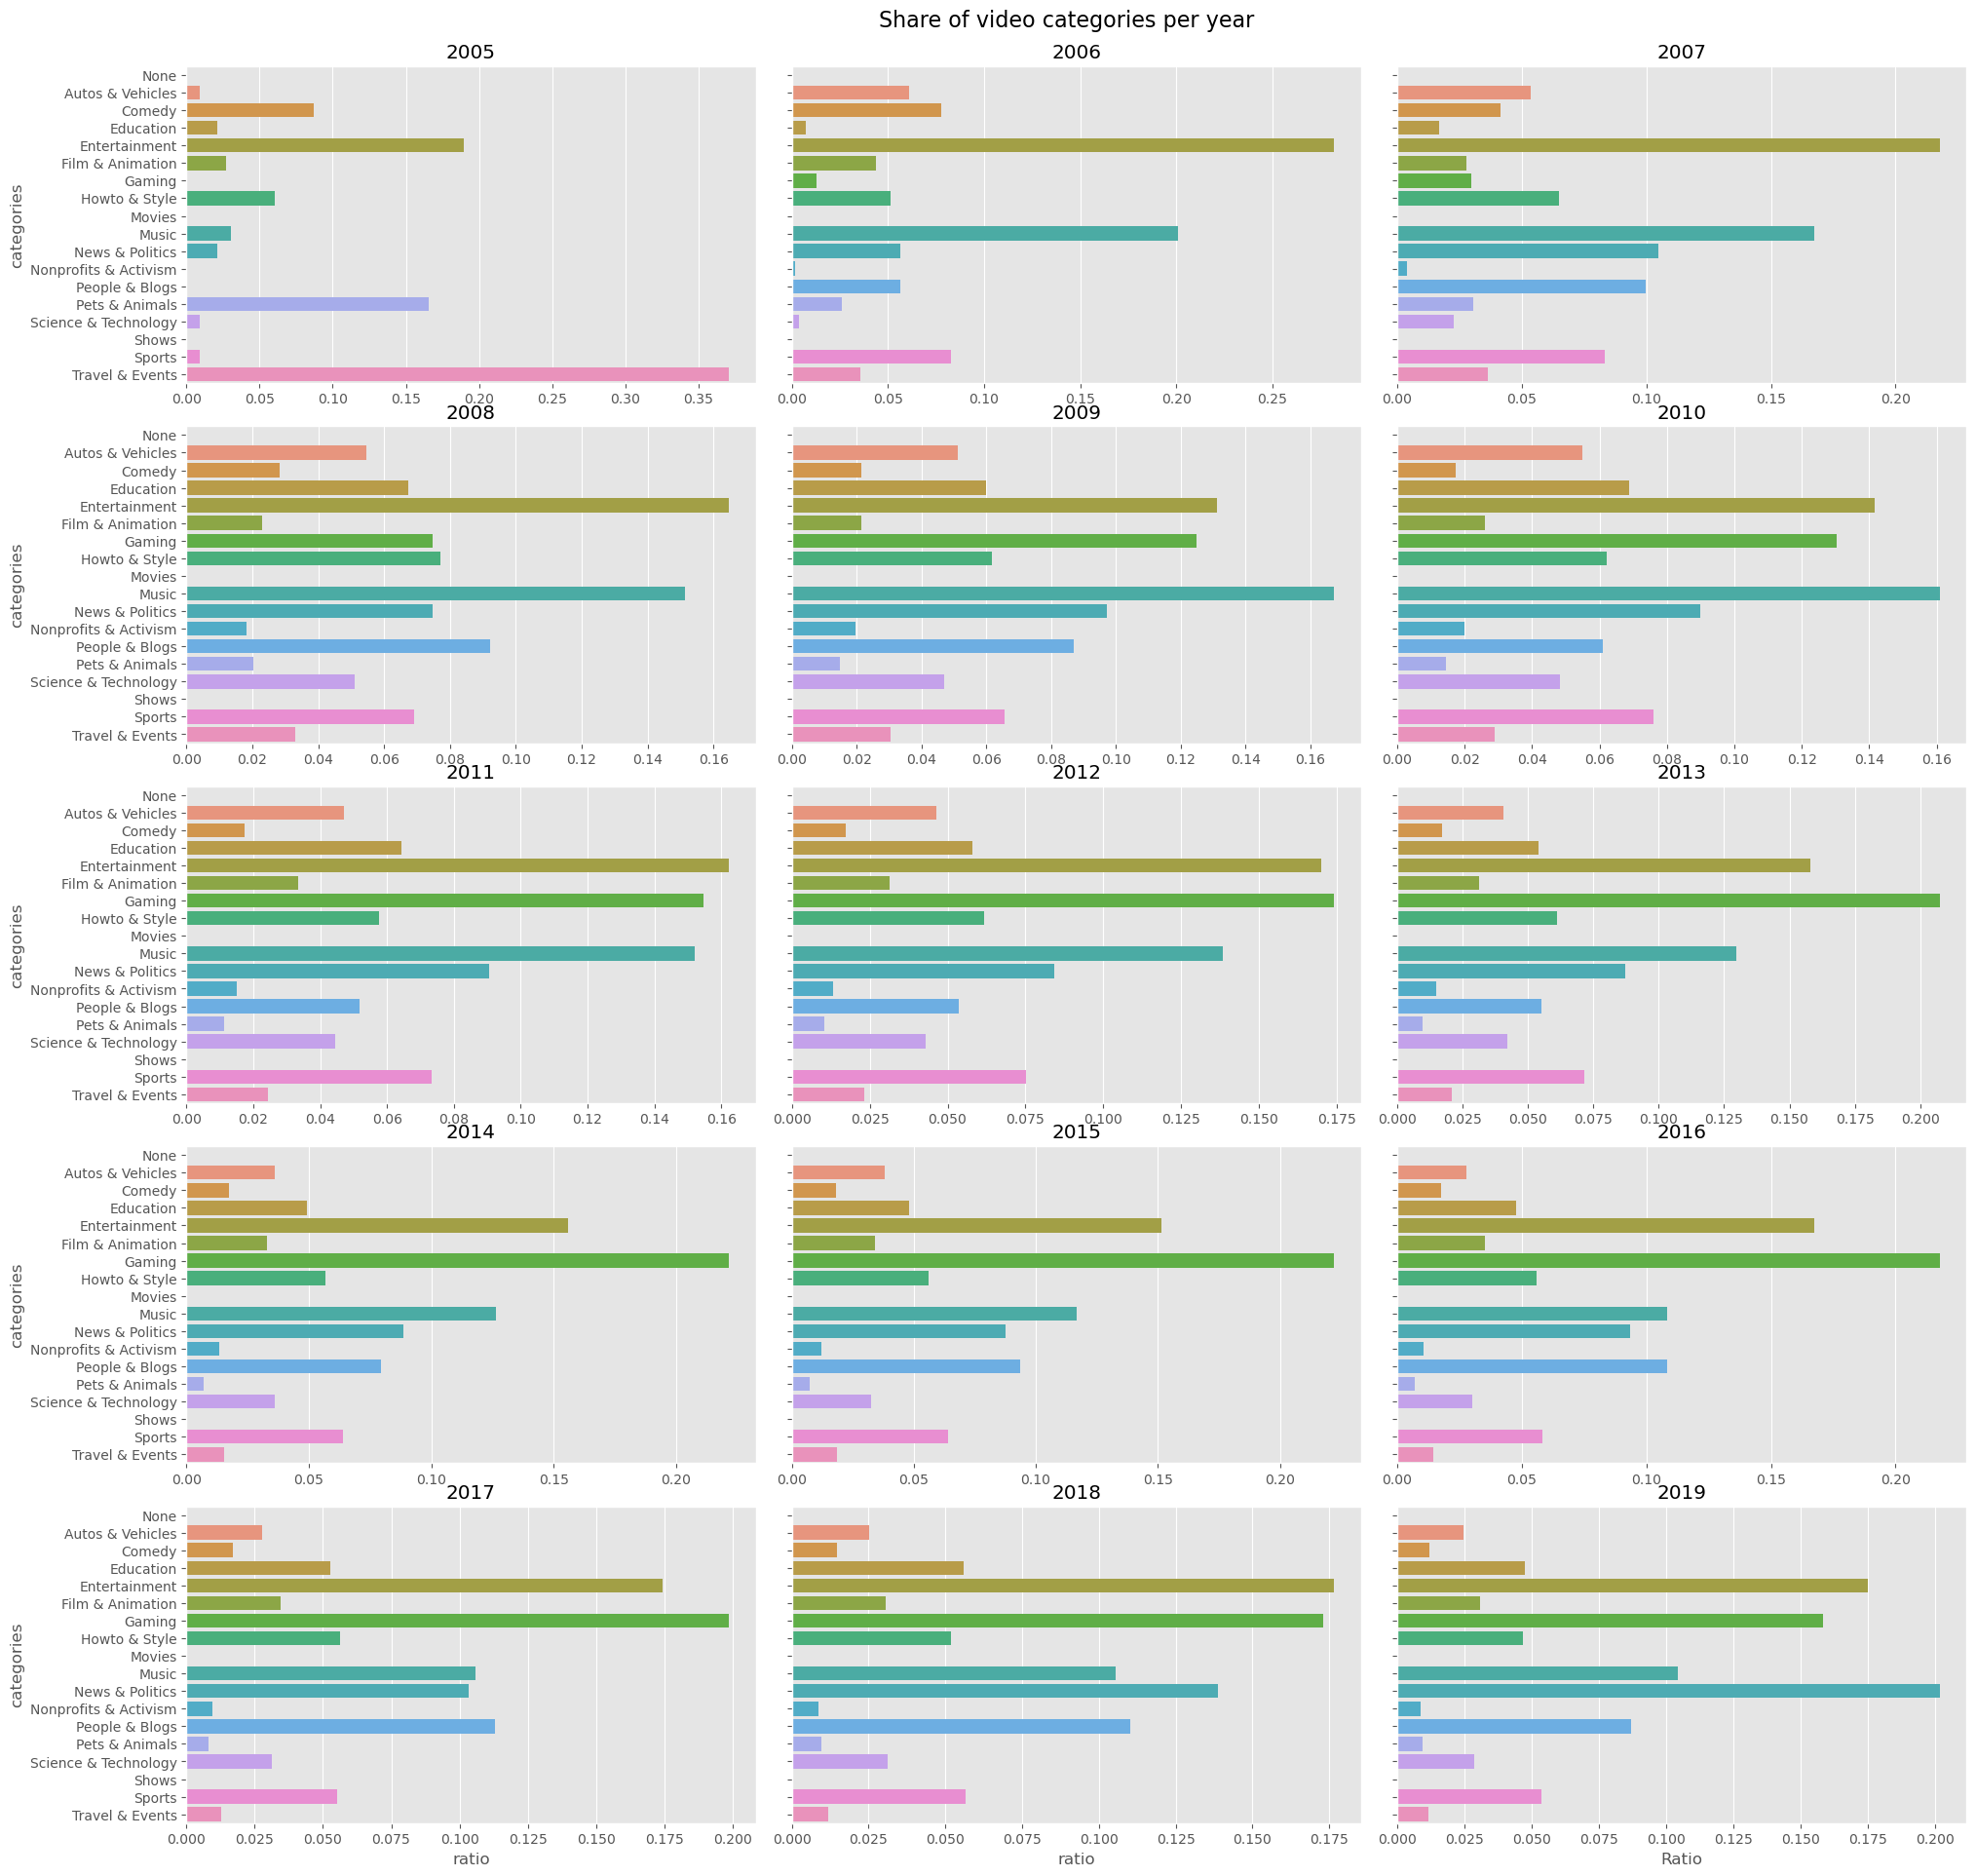

In [176]:
fig, axs = plt.subplots(5, 3, sharey=True, figsize=(19, 19))
fig.suptitle("Share of video categories per year", fontsize=16, y=1)

fig.tight_layout()
for year, ax in zip(years, axs.ravel()):
    p = sns.barplot(
        ax=ax, data=ratios[ratios["year"] == year], y="categories", x="ratio"
    )
    idx = year - 2005
    if idx % 3 != 0:
        p.set(ylabel=None)
    if idx < 12:
        p.set(xlabel=None)
    ax.set_title(year)

plt.xlabel("Ratio")
plt.show()

We can see that the categories `Movies`, `Shows` and `None` do not contain a lot of videos. We explore this in the cells below.

## Movies, Shows and None categories

In [ ]:
# Note that we used "None" previously to represent the "" category in the plots
abnormal_cats: pd.DataFrame = ps_metadatas_df[ps_metadatas_df.categories.isin(["Movies", "Shows", ""])].to_pandas()

In [33]:
abnormal_cats.groupby("categories").size()

categories
          1522
Movies       5
Shows       41
dtype: int64

We can just see some of the data points

In [34]:
abnormal_cats[abnormal_cats.categories == "Movies"]

,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,upload_date,view_count
display_id,,,,,,,,,,,
L3thFGDGAS8,Movies,UCwaNuezahYT3BOjfXsne2mg,2019-11-11,Let's turn Taylor Swift's OUT OF THE WOODS int...,202.0,229,2146.0,"Out Of The Woods,out of the woods taylor swift...",Taylor Swift - Out Of The Woods PARODY,2016-01-14,170642
rpUkpMfMWtw,Movies,UC6xOVUMstTf08rUgOFbyPEA,2019-11-14,A comical take on the BMC's inefficiency and t...,107.0,273,3608.0,"BMC,government og india,government,indian gove...",SnG: BMC! You Screwed Me,2014-10-27,189267
9wBn1s_l2kE,Movies,UC4zJAMaYN592qQhMR2OfX_Q,2019-11-02,In no other country in the world does a girl's...,19.0,190,877.0,"clisare,irish youtuber,irish girl,funny irish ...",What An Irish Girl's Fake Tan Means | Clisare ...,2015-10-20,32070
UtUH7-mYBLA,Movies,UC4zJAMaYN592qQhMR2OfX_Q,2019-11-02,Why do women listen to songs with such degradi...,38.0,227,576.0,"clisare,misogynistic,Robin Thicke (Musical Art...",SEXIST SONG LYRICS / Clisare,2013-10-14,36410
fVqOyXdDQTc,Movies,UC4zJAMaYN592qQhMR2OfX_Q,2019-11-02,The long-awaited sequel. For the one year anni...,92.0,110,2836.0,"clisare,yeousch,irish,girl,ireland,sydney,coll...",Shite Irish Mammies Say // Clisare,2013-02-24,284059


We can see that all videos with the categori `Movies` came out between 2013 and 2016.

In [35]:
abnormal_cats[abnormal_cats.categories == "Shows"].head()

,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,upload_date,view_count
display_id,,,,,,,,,,,
RGTIpnn7tKQ,Shows,UCVi2lI40LetxLBKn-rtWC3A,2019-11-04,http://www.funimation.com/kamisama-kiss\n\nAba...,293.0,1441,15358.0,"funimation,anime,animation,japanese,kamisama k...",Kamisama Kiss - 1 - Nanami Becomes A God,2012-11-28,1342616
45N75Qb-BtU,Shows,UCVi2lI40LetxLBKn-rtWC3A,2019-11-04,Available on Blu-Ray/DVD Combo 12/18/12\nhttp:...,27.0,1470,822.0,"funimation,anime,animation,japanese,shakuhan,n...",Shakugan no Shana II - 1 - Time Again,2012-11-02,90632
HuBY7aX6BpE,Shows,UCVi2lI40LetxLBKn-rtWC3A,2019-11-04,Available on Blu-Ray/DVD Combo 12/18/12\nhttp:...,13.0,1465,427.0,"funimation,anime,animation,japanese,shakuhan,n...",Shakugan no Shana II - 2 - Prelude to Everything,2012-11-02,52095
aXsk5pE7U5k,Shows,UCVi2lI40LetxLBKn-rtWC3A,2019-11-04,Available on Blu-Ray/DVD Combo 12/18/12\nhttp:...,14.0,1465,452.0,"funimation,anime,animation,japanese,shakuhan,n...",Shakugan no Shana II - 4 - The Dismayed Girls,2012-11-02,52371
NjLnlvFNvMA,Shows,UCVi2lI40LetxLBKn-rtWC3A,2019-11-04,Available on Blu-Ray/DVD Combo 12/18/12\nhttp:...,14.0,1465,442.0,"funimation,anime,animation,japanese,shakuhan,n...",Shakugan no Shana II - 3 - The Suspicious Tran...,2012-11-02,51336


In [37]:
abnormal_cats[abnormal_cats.categories == "Shows"].upload_date.min(), abnormal_cats[abnormal_cats.categories == "Shows"].upload_date.max()

(datetime.date(2012, 8, 13), datetime.date(2013, 1, 18))

We can see that the `Shows` category only existed for a small amout of time, between the August 2012 to January 2013 (5 months).

In [36]:
abnormal_cats[abnormal_cats.categories == ""].head()

,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,upload_date,view_count
display_id,,,,,,,,,,,
mv8d1j8O_KY,,UCzS3-65Y91JhOxFiM7j6grg,2019-11-14,Will Ferrell & Adam McKay think back to just l...,NaN,139,NaN,"funnyordie,funny or die,funny,comedy,sketch,lo...",Will Ferrell & Adam McKay Discuss The Art of T...,2017-09-13,9706
dSG8bWaA2vY,,UCzS3-65Y91JhOxFiM7j6grg,2019-11-14,Subscribe to Todd Kruger: http://www.funnyordi...,NaN,206,NaN,"funnyordie,funny or die,funny,comedy,sketch,lo...","Todd Kruger: The Pretentious Bum - ""The Edible...",2016-02-18,3797
D8_baAUFi6k,,UCzQxQEjCprHzJmWmgSLBjqQ,2019-11-18,Release date: 13 of May Download on Beatport: ...,NaN,53,NaN,,Slideback - Harmonica (Original Mix) [OFFICIAL...,2013-05-08,1193
TZmYztItVEQ,,UCzOrpRAPhzLet9lCv1unRqw,2019-11-01,"In the second Live show episode of Love Gurus,...",NaN,4698,NaN,"Love Guru Live Show,Advice On Love and Relatio...",Love Guru Live Show - Episode 2 | Socialpost,2019-06-15,529
mmqtirodB7Y,,UCrpVInV3uywvK-Df0fO12-Q,2019-10-31,Become a sponsor on Patreon and get invited to...,NaN,8035,NaN,"Nintendo Switch,Switch,Nintendo Switch News,Ni...",Nintendo Direct Live Reaction! March 8th 2018,2018-03-08,32264


In [38]:
abnormal_cats[abnormal_cats.categories == ""].upload_date.min(), abnormal_cats[abnormal_cats.categories == ""].upload_date.max()

(datetime.date(2007, 8, 1), datetime.date(2019, 9, 30))

In [60]:
non_null_counts = abnormal_cats[(abnormal_cats.categories == "") & (abnormal_cats.dislike_count.notnull())].size, \
                  abnormal_cats[(abnormal_cats.categories == "") & (abnormal_cats.like_count.notnull())].size

print(f"None category videos with dislikes    : {non_null_counts[0]}\n"
      f"None category videos with likes       : {non_null_counts[1]}")

null_counts = abnormal_cats[(abnormal_cats.categories == "") & (abnormal_cats.dislike_count.isna())].size, \
              abnormal_cats[(abnormal_cats.categories == "") & (abnormal_cats.like_count.isna())].size

print(f"None category videos with no dislikes : {null_counts[0]}\n"
      f"None category videos with no likes    : {null_counts[1]}")

None category videos with dislikes    : 9042
None category videos with likes       : 9042
None category videos with no dislikes : 7700
None category videos with no likes    : 7700


We can see above that the `None` category seems to not have likes nor dislikes. We check this by counting such videos.

### Save results

In [178]:
ratios.to_csv("generated/vids_count_by_cat_per_year.csv", index=False)

In [32]:
count_sorted.to_csv("generated/vids_per_month.csv", index=False)